In [4]:
pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


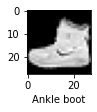

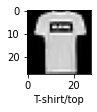

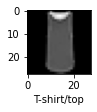

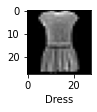

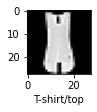

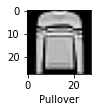

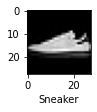

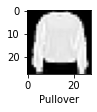

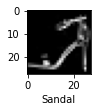

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: zm71t1t4
Sweep URL: https://wandb.ai/dl_sumit/Deep_learning_final1/sweeps/zm71t1t4


wandb: Agent Starting Run: e8w563bi with config:
wandb: 	Optimization: RMS
wandb: 	activation: sigmoid
wandb: 	epochs: 15
wandb: 	hls: 5
wandb: 	hn: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	size_batch: 32
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Deep_learning_final1.ipynb.


wandb: Ctrl + C detected. Stopping sweep.


<Figure size 432x288 with 0 Axes>

Error in callback <function _WandbInit._pause_backend at 0x7fd176937c10> (for post_run_cell):


BrokenPipeError: ignored

In [5]:
#Terminologies
#xtr----Xtrain, ytr----Ytrain, xte----Xtest, yte----Ytest
#inn----Input Neuron, otn----Output Neuron, hls----Hidden Layers, Input 'u'---Input to the neuron, 'v'----Output from the neuron



from keras.datasets import fashion_mnist
import wandb
import os
import numpy as np 
import matplotlib.pyplot as plt # for data visualization
import copy
import math
(xtr, ytr), (xte, yte) = fashion_mnist.load_data()
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Plotting the images
for k in range(9):
  #Subplot definition 
  plt.subplot(330+1+k)
  #Data plotting
  plt.imshow(xtr[k], cmap=plt.get_cmap('gray'))                                        
  plt.xlabel(class_names[ytr[k]])
  plt.show()

xtr = xtr.reshape(60000, 784)/255  #Data Normalization
xte = xte.reshape(10000, 784)/255

# relu function.
def relu(x):
    return np.maximum(0, x)

# derivative of relu
def drelu(x):
    if x > 0:
      return 1
    elif x <= 0:
      return 0

# Definition of logistic function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


# derivative of tanh function.
def dtanh(x):
    return 1.0 - np.square(np.tanh(x))


# derivate of logistic function
def dsigmoid(x):
    
    return sigmoid(x) * (1 - sigmoid(x))



# Definition of an Activation function
def activ(ini, hn, activation):
    if activation == "sigmoid":
        Oi = np.empty([hn, 1])
        for k in range(hn):
            Oi[k] = sigmoid(ini[k])
        return Oi
    elif activation == "tanh":
        Oi = np.empty([hn, 1])
        for k in range(hn):
            Oi[k] = np.tanh(ini[k])
        return Oi
    elif activation == "relu":
      Oi = np.empty([hn, 1])
      for k in range(hn):
            Oi[k] = relu(ini[k])
      return Oi

# Activation function derivative definition
def deractiv(ini, hn, activation):
    if activation == "sigmoid":
        Oi = np.empty([hn, 1])
        for k in range(hn):
            Oi[k] = dsigmoid(ini[k])
        return Oi
    elif activation == "tanh":
        Oi = np.empty([hn, 1])
        for k in range(hn):
            Oi[k] = dtanh(ini[k])
        return Oi
    elif activation == "relu":
        Oi = np.empty([hn, 1])
        for k in range(hn):
            Oi[k] = drelu(ini[k])
        return Oi

# Output function
def OUT(ul, otn):
    outp = np.empty([otn, 1])
    tot = 0
    for k in range(otn):
        tot = tot + np.exp(ul[k])
    for k in range(otn):
        outp[k] = np.exp(ul[k]) / tot
    return outp

# forward propogation  Returns the final probability distribution for each of the label.
def forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation):
    v[0] = xtr[la].reshape(-1, 1)
    for k in range(1, hls):
        u[k] = np.dot(W[k], v[k-1]) + b[k]
        v[k] = activ(u[k], hn, activation)
    u[hls] = np.dot(W[hls], v[hls-1]) + b[hls]
    y_predicted = OUT(u[hls], otn)
    return y_predicted


# Definition of an Initialization function, to intializer W's and b's
def init(W, b, inn, hls, hn, otn, initialization):
    if initialization == "random":
          
           W[1] = np.random.rand(hn,inn)*0.01
           for k in range(2,hls):
              
            W[k] = (np.random.rand(hn, hn))*0.01   
           for k in range(1,hls):
              b[k] = np.zeros([hn, 1])
        
             
              b[hls] = np.zeros([otn, 1])
              W[hls] = np.random.rand(otn, hn)*0.01

    if initialization == "xavier":
           variance1 = 2.0 / (inn + otn)
           std_dev1 = np.sqrt(variance1)
           W[1] = np.random.normal(0.0, std_dev1, (hn, inn))
    for k in range(2,hls):
        variance2 = 2.0 / (hn + hn)
        std_dev2 = np.sqrt(variance2)
        W[k] = np.random.normal(0.0, std_dev2,(hn, hn))
              
    for k in range(1,hls):
        b[k] = np.zeros([hn, 1])
        variance3 = 2.0 / (otn + hn)
        std_dev3 = np.sqrt(variance3)
        W[hls] = np.random.normal(0.0, std_dev3, (otn, hn))
        b[hls] = np.zeros([otn, 1])

    return W, b

# One hot vector
#In order to classify one output at a time
def hot(m, n):
    h = np.zeros([n, 1])
    h[m] = 1
    return h

#Backpropagation step, in order to find the partial derivatives of the loss function w.r.t different parametres
def Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los):
    grad_u = {}
    grad_v = {}
    value = np.empty([otn,1])
    if los == "cross_entropy":
        value = y_predicted - hot(ytr[la], otn)
    elif los == "squared_error":
        for k in range(otn):
            value[k] = np.dot(np.transpose(np.multiply(y_predicted, y_predicted - hot(ytr[la], otn))), hot(k, otn) - np.ones([otn,1]) * y_predicted[k])
    grad_u[hls] = value
    for i in range(hls, 0, -1):
        if i in gradW.keys():
            gradW[i] = gradW[i] + np.dot(grad_u[i],np.transpose(v[i-1]))
            gradb[i] = gradb[i]  + grad_u[i]
        else:
            gradW[i] = np.dot(grad_u[i],np.transpose(v[i-1]))
            gradb[i] = grad_u[i]
        grad_v[i-1] = np.dot(np.transpose(W[i]), grad_u[i])
        if i != 1:
            grad_u[i-1] = np.multiply(grad_v[i-1], deractiv(u[i-1], hn, activation).reshape(-1, 1))
    return gradW, gradb

# loss function : squared error loss, cross entropy
def LOSS(y_predicted, ytr, los, la, otn):
    if los == "cross_entropy":
        return -np.log(y_predicted[ytr[la]])
    elif los == "squared_error":
        return np.square(y_predicted - hot(ytr[la], otn))

# Computation of Accuracy with trained W's and b's
def acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation):
    accuracy = 0
    y_p = np.zeros(yte.shape)
    for la in range(10000):
        u = {}
        v = {}
        v[0] = xte[la].reshape(-1, 1)
        for k in range(1, hls):
            u[k] = np.dot(W[k], v[k-1]) + b[k]
            v[k] = activ(u[k], hn, activation)
        u[hls] = np.dot(W[hls], v[hls-1]) + b[hls]
        y_predicted = OUT(u[hls], otn)
        ix = 0
        value = 0
        for k in range(np.shape(y_predicted)[0]):
            if value < y_predicted[k]:
                ix = k
                value = y_predicted[k]
        y_p[la] = ix
        accuracy += int(ix == yte[la])
    print("accuracy is ", accuracy/100, "%")
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs = None, preds = y_p, y_true = yte, class_names = class_names)})
    wandb.log({"test_acc": accuracy / 100})
    acc_vali = 0
    vali_total_loss = 0 
    for la in range(54000, 60000):
        u = {}
        v = {}
        y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
        loss_vali = LOSS(y_predicted, ytr, los, la, otn)
        vali_total_loss = vali_total_loss + loss_vali
        ix = 0
        value = 0
        for k in range(np.shape(y_predicted)[0]):
            if value < y_predicted[k]:
                ix = k
                value = y_predicted[k]
        acc_vali = acc_vali + int(ix == ytr[la])
    print("Validation Accuracy is ", acc_vali/60, "%")
    print("Total Validation Loss is ", vali_total_loss)
    wandb.log({"val_acc" : acc_vali/60})
    wandb.log({"val_loss" : vali_total_loss})

# Different Optimization Methods i.e. Momentum based Gradient Descent Method Definition
def momentumbasedgd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los):
        gamma  = 0.9
        W_prev = copy.deepcopy(W)
        b_prev = copy.deepcopy(b)
        
        for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total = loss_total + loss_current
                Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        update_W = gamma * W_prev[k] * int(p != 0) + learning_rate * gradW[k]
                        W[k] = W[k] - update_W
                        W_prev[k] =  copy.deepcopy(update_W)
                    for k in range(1, hls):    
                        update_b = gamma * b_prev[k] * int(p != 0) + learning_rate * gradb[k]
                        b[k] = b[k] - update_b
                        b_prev[k] =  copy.deepcopy(update_b)
                    gradW = {}
                    gradb = {}
            
            wandb.log({"loss": loss_total})
            wandb.log({"epoch": p})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)

# Different Optimization methods i.e., RMSprop
def RMS(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los): 
         Ep = 1e-8
         B = 0.1
         B1 = 0.9
         update_b = {}
         update_W = {}
         for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total = loss_total + loss_current
                Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        if(p==0):
                            update_W[k] = np.zeros(gradW[k].shape, dtype=float)
                            update_b[k] = np.zeros(gradb[k].shape, dtype=float)

                    for k in range(1, hls+1):
                        update_W[k] = B1 * update_W[k] + (1 - B1) * np.square(gradW[k])
                        W[k] = W[k]- (learning_rate / np.sqrt(update_W[k] + Ep)) * gradW[k]

                    for k in range(1, hls):
                        update_b[k] = B1 * update_b[k] + (1 - B1) * np.square(gradb[k])
                        b[k] -= (learning_rate / np.sqrt(update_b[k] + Ep)) * gradb[k]
                    gradW = {}
                    gradb = {}
           
                    wandb.log({"loss": loss_total})
                    wandb.log({"epoch": p})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)

# Different Optimization methods i.e., Nesterov Accelerated gradient descent
def Nesterovagd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los): 
         W_prev = copy.deepcopy(W)
         b_prev = copy.deepcopy(b)
         gamma  = 0.9
         for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        update_W = gamma * W_prev[k] * int(p != 0)
                        W[k] = W[k] - update_W
                    for k in range(1, hls):    
                        update_b = gamma * b_prev[k] * int(p != 0)
                        b[k] = b[k] - update_b
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total += loss_current
                Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        update_W = gamma * W_prev[k] * int(p != 0) + learning_rate * gradW[k]
                        W[k] -= update_W
                        W_prev[k]=  copy.deepcopy(update_W)
                    for k in range(1, hls):    
                        update_b = gamma * b_prev[k] * int(p != 0) + learning_rate * gradb[k]
                        b[k] -= update_b
                        b_prev[k] = copy.deepcopy(update_b)
                    gradW = {}
                    gradb = {}
            wandb.log({"epoch": p})
            wandb.log({"loss": loss_total})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)  
           

# Different Optimization Methods i.e. Stochastic Gradient Descent Method Definition
def stochasticgd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los):
          for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total = loss_total + loss_current
                Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        W[k] = W[k] - learning_rate * gradW[k]

                    for k in range(1, hls):    
                        b[k] = b[k] - learning_rate * gradb[k]
                    gradW = {}
                    gradb = {}
            
            wandb.log({"loss": loss_total})
            wandb.log({"epoch": p})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)



# Different Optimization Methods definitions i.e. Nesterov Adaptive Movement Estimation  
def Nesterovadapt(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los): 
        B1 =  0.9
        Ep = 1e-8
        B2 = 0.999
        updatem_W = {}
        updatem_b = {}
        updatev_W = {}
        updatev_b = {}
        for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total = loss_total + loss_current
                gradW, gradb = Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        if(p == 0):
                            updatem_W[k] = np.zeros(gradW[k].shape, dtype=float)
                            updatev_W[k] = np.zeros(gradW[k].shape, dtype=float)
                            updatem_b[k] = np.zeros(gradb[k].shape, dtype=float)
                            updatev_b[k] = np.zeros(gradb[k].shape, dtype=float)
                    for k in range(1, hls+1):
                        updatem_W[k] = B1 * updatem_W[k] + (1 - B1) * gradW[k]
                        updatem_W_cap = updatem_W[k] / (1 - math.pow(B1, (la / size_batch) + 1))
                        updatev_W[k] = B2 * updatev_W[k] + (1 - B2) * np.square(gradW[k])
                        updatev_W_cap = updatev_W[k] / (1 - math.pow(B2,(la / size_batch) + 1))
                        W[k] = W[k] - (learning_rate / np.sqrt(updatev_W_cap + Ep)) * (B1 * updatem_W_cap + ((1 - B1) / (1 - math.pow(B1,(la / size_batch) + 1)) * gradW[k])) 
                    for k in range(1, hls):
                        updatem_b[k] = B1 * updatem_b[k] + (1 - B1) * gradb[k]
                        updatem_b_cap = updatem_b[k] / (1 - math.pow(B1, (la / size_batch) + 1))
                        updatev_b[k] = B2 * updatev_b[k] + (1 - B2) * np.square(gradb[k])
                        updatev_b_cap = updatev_b[k] / (1 - math.pow(B2, (la / size_batch) + 1))
                        b[k] = b[k] - (learning_rate / np.sqrt(updatev_b_cap + Ep)) * (B1 * updatem_b_cap + ((1 - B1) / (1 - math.pow(B1,(la / size_batch) + 1)) * gradb[k]))
                    gradW = {}
                    gradb = {}
            
            wandb.log({"loss": loss_total})
            wandb.log({"epoch": p})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)

#Different Optimization methods i.e., Adaptive Movement Estimation  
def adaptivem(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los): 
        updatev_W={}
        updatem_W={}       
        updatev_b={}
        updatem_b={}
        Ep  = 1e-8
        B1  =  0.9
        B2 =  0.999
        for p in range(epochs):
            gradW = {}
            gradb = {}
            loss_total = 0
            for la in range(set_train):
                y_predicted = forwardprop(xtr, hls, hn, inn, otn, W, b, u, v, la, activation)
                loss_current = LOSS(y_predicted, ytr, los, la, otn)
                loss_total = loss_total + loss_current
                Backprop(ytr, hls, hn, inn, otn, W, b, u, v, gradW, gradb, la, y_predicted, activation, los)
                if la % size_batch == 0:
                    for k in range(1, hls+1):
                        if(p == 0):
                            updatem_W[k] = np.zeros(gradW[k].shape, dtype=float)
                            updatem_b[k] = np.zeros(gradb[k].shape, dtype=float)
                            updatev_W[k] = np.zeros(gradW[k].shape, dtype=float)
                            updatev_b[k] = np.zeros(gradb[k].shape, dtype=float)
                    for k in range(1, hls+1):
                        updatem_W[k] = B1 * updatem_W[k] + (1 - B1) * gradW[k]
                        updatem_W_cap = updatem_W[k] / (1 - math.pow(B1, (la / size_batch) + 1))
                        updatev_W[k] = B2 * updatev_W[k] + (1 - B2) * np.square(gradW[k])
                        updatev_W_cap = updatev_W[k] / (1 - math.pow(B2, (la / size_batch) + 1))   
                        W[k] = W[k] - (learning_rate / np.sqrt(updatev_W_cap + Ep)) * updatem_W_cap

                    for k in range(1, hls):
                        updatem_b[k] = B1 * updatem_b[k] + (1 - B1) * gradb[k]
                        updatem_b_cap = updatem_b[k] / (1-math.pow(B1,(la / size_batch) + 1))
                        updatev_b[k] = B2 * updatev_b[k] +(1 - B2) * np.square(gradb[k])
                        updatev_b_cap = updatev_b[k] / (1-math.pow(B2, (la / size_batch) + 1))
                        b[k] = b[k] - (learning_rate / np.sqrt(updatev_b_cap + Ep)) * updatem_b_cap
                    gradW = {}
                    gradb = {}
            
            wandb.log({"loss": loss_total})
            wandb.log({"epoch": p})
            acc(xte, yte, xtr, ytr, W, b, hls, otn, hn, activation)     


# complete training of the dataset
def trning(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, Optimization, set_train, activation, los, initialization):
    init(W, b,inn, hls, hn, otn, initialization)
    if Optimization == "stochasticgd":
        stochasticgd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    elif Optimization == "momentumbasedgd":
          momentumbasedgd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    elif Optimization == "Nesterovadapt":
          Nesterovadapt(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    elif Optimization == "RMS":
          RMS(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    elif Optimization == "adaptivem":
          adaptivem(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    elif Optimization == "nesterovagd":
          Nesterovagd(xtr, ytr, hls, hn, inn, otn, W, b, u, v, learning_rate, epochs, size_batch, set_train, activation, los)
    

# Sweep config for wandb plotting

sweep_config = {
    'name'  : "Sumit Sharma", 
    'method': 'random', 
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'   
    },

    'parameters': {

        'hls': {
            'values': [3,4, 5]
        },
        'epochs': {
            'values': [10, 15]
        },
        'hn': {
            'values': [32, 64,128]
        },
        'learning_rate': {
            'values': [1e-2,1e-3,5e-3]
        },
        'initialization': {
            'values': ["random","xavier"]
        },
        'size_batch': {
            'values': [32,64]
        },
        'Optimization': {
            'values': ["momentumbasedgd","stochasticgd","Nesterovadapt","RMS","adaptivem","nesterovagd"]
        },
        'activation': {
            'values': ["sigmoid","relu","tanh"]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project = "Deep_learning_final1")

#Initialization for neurons and training
otn = 10
set_train = 54000
inn = 784
u = {}
v = {}
W = {}
b = {}
los = "cross_entropy"
os.environ['WANDB_NOTEBOOK_NAME'] = 'Deep_learning_final1.ipynb'
wandb.login()

def execute():
    wandb.init(config = sweep_config)
    wandb.log({"images" : wandb.Image(plt)})
    config = wandb.config
    wandb.run.name = "hl_{}_hn_{}_bs_{}_ac_{}_learning_rate_{}_init_{}_".format(config.hls, config.hn, config.size_batch , config.activation ,config.learning_rate, config.initialization)
    trning(xtr, ytr, config.hls, config.hn, inn, otn, W, b, u, v, config.learning_rate, config.epochs, config.size_batch, config.Optimization, set_train, config.activation, los, config.initialization)
    
wandb.agent(sweep_id, execute)
